In [1]:
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from src.lrg_eegfc import *

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


In [2]:
data_dict = {}
int_label_pos_map = {}

for pat in patients_list:
    data_dict[pat] = {}
    #
    patnum = int(pat.split('_')[-1])
    patpath = mat_path / pat
    #
    ch_dat = pd.read_csv(patpath / f'Implant_pat_{patnum}.csv')
    ch_names = pd.read_csv(patpath / 'channel_labels.csv')
    #
    int_label_pos_map[pat] = ch_names.merge(ch_dat,on='label', how='left')
    df = int_label_pos_map[pat][['x', 'y', 'z']]
    df = df.apply(lambda s: s.str.replace(',', '.', regex=False).astype(float))
    #
    for phase in phase_labels:
        data_dict[pat][phase] = {}
        tmp_mat = load_mat_pat_data(pat, phase, mat_path)
        #
        data_dict[pat][phase]['data'] = tmp_mat['Data']
        tmp_shape = tmp_mat['Data'].shape
        #
        if tmp_shape[0] > tmp_shape[1]:
            data_dict[pat][phase]['data'] = data_dict[pat][phase]['data'].T
        try:
            # Check if 'Parameters' is in the loaded data
            for param in tmp_mat['Parameters'].dtype.names:
                if param in param_keys_list:
                    data_dict[pat][phase][param] = tmp_mat['Parameters'][param][0][0][0][0]
        except:
            print(f'No parameters found for {pat} {phase}', end='\r', flush=True)
            continue

### Split in time windows

In [3]:
patient = 'Pat_02'
phase = 'rsPre'
#
corr_net_filt = dict(threshold=0)
#
data_pat_phase = data_dict[patient][phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']
#
n_intervals = 100
interval_length = int(data_pat_phase_ts.shape[1] // n_intervals)
n_intervals, interval_length

(100, 13232)

In [18]:
corr_mat_band_tw = {}
for band_name, (low, high) in tqdm(BRAIN_BANDS.items()):
    corr_mat_band_tw[band_name] = {}
    for i in range(n_intervals):
        start = i * interval_length
        end = (i + 1) * interval_length
        interval_data = data_pat_phase_ts[:, start:end]
        filter_data = bandpass_sos(interval_data, low, high, fs, 3)
        corr_mat = build_corr_network(filter_data, **corr_net_filt)
        corr_mat_band_tw[band_name][i] = corr_mat

100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


In [ ]:
corr_nets = {band_name: {i: nx.from_numpy_array(corr_mat_band_tw[band_name][i]) for i in range(n_intervals)} for band_name, (low, high) in tqdm(BRAIN_BANDS.items())}

corr_nets_th = {'delta': {i: threshold_graph(G0, 0.9) for i, G0 in corr_nets['delta'].items()}}
clear_output()

Computing threshold stats:   7%|▋         | 8/117 [00:00<00:01, 71.36it/s]

In [6]:
# 1. collect your data pairs (t1, dS1) for each time step into a list
data_list = []
for i, arr in corr_nets_th['delta'].items():
    Gcc, _ = get_giant_component_leftoff(arr[1])
    _, dS1, _, t1 = entropy(Gcc)
    data_list.append((t1[1:], dS1))

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:91: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


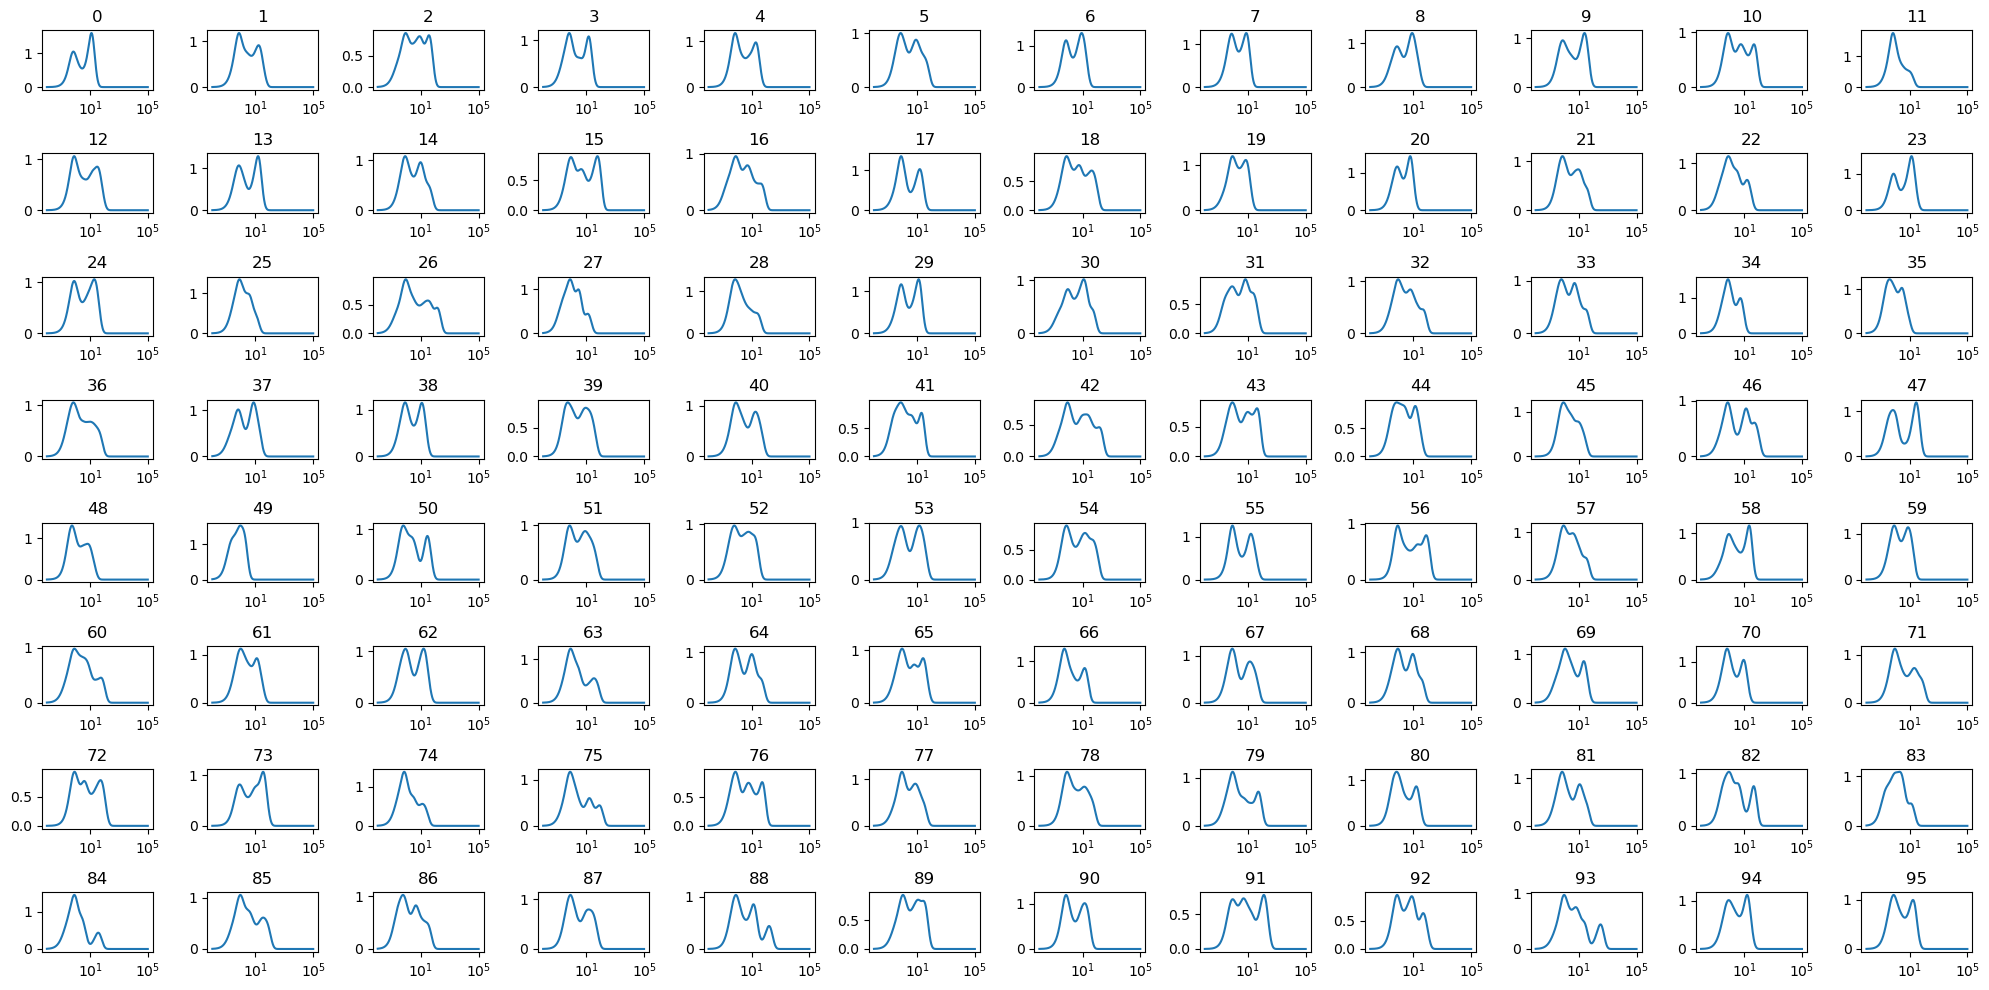

In [16]:
fig, ax = plt.subplots(8, len(corr_nets_th['delta'])//8, figsize=(20, 10))
ax = ax.flatten()
for i, arr in corr_nets_th['delta'].items():
    if i >= len(corr_nets_th['delta'])//8*8:
        break
    ax[i].set_title(i)
    Gcc, removed_nodes = get_giant_component_leftoff(arr[1])
    pos = nx.spring_layout(Gcc, seed=42)
    labeldict = {k: v for k, v in int_label_pos_map[pat]['label'].to_dict().items() if k not in removed_nodes}
    colorlist = [v for k,v in labeldict.items()]
    values = list(map(int_label_pos_map[pat]['label'].to_dict().get, removed_nodes))
    # print(values)
    # 1. extract only the letters you actually have
    letters = sorted({label[0].upper() for label in labeldict.values()})

    # 2. spread them evenly around the hue circle
    hues = [i / len(letters) for i in range(len(letters))]

    # 3. build your base‐color map
    base_colors = {
        letter: mcolors.hsv_to_rgb((hue, 1, 1))
        for letter, hue in zip(letters, hues)
    }

    def node_color(label: str) -> str:
        """
        label: e.g. 'A2', 'C10', etc.
        returns: hex color string where the base hue is set by the first letter
                and the intensity (1–10) modulates saturation towards white.
        """
        letter = label[0].upper()
        intensity = int(label[1:]) % 10 or 10
        t = intensity / 10
        rgb = base_colors.get(letter, (0.5, 0.5, 0.5))
        mixed = tuple((1 - t) + c * t for c in rgb)  # blend with white
        return mcolors.to_hex(mixed)


    colors = {node: node_color(node) for node in colorlist}
    cl= list(colors.values())

    # nx.draw(Gcc, pos, ax=ax[i], node_color=cl, with_labels=True, node_size=50, font_size=8, labels=labeldict)
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    [Sm1, dS1, VarL1, t1] = entropy(Gcc)
    ax[i].plot(t1[1:], dS1)
    ax[i].set_xscale('log')
fig.tight_layout()